# **NYC 311 Request Analysis**

## **Problem Statement**

The New York City Department of Housing Preservation and Development (HPD) needs help answering the following key questions:

* What type of housing complaint should be prioritized first based on frequency, severity, and other factors in the 311 data?

* Are certain boroughs, ZIP codes, or streets experiencing more severe complaints of this top priority type? 

* Does the top complaint type correlate with any particular housing/building characteristics? 

* Can a predictive model be developed to forecast future complaints of the priority type?



## **Goal**

My goal is to deliver data-backed recommendations that provide actionable insights to help HPD manage its growing volume of 311 cases and build a predictive model for forecasting future complaints.

## **NYC 311 Complaint Dataset**

The primary dataset used for this analysis is a preprocessed version of the NYC 311 Complaints dataset obtained from the NYC OpenData portal. This public dataset contains records of complaints filed through the 311 system by NYC residents from 2010 to August 2019. For the purposes of this analysis, the raw 311 data was preprocessed to contain only relevant columns and rows to make the volume more manageable. While similar to 311 datasets used in other analyses, minor differences in the data may lead to small numerical discrepancies. However, these differences do not impact the overall findings and conclusions drawn from the data to address the key questions posed by the NYC Department of Housing Preservation and Development regarding 311 complaint insights.

## **Dataset for Housing**

Here is a revised paragraph about the building characteristics dataset without directly mentioning using CSV files from another source:

The second dataset used in this analysis contains building characteristic information for houses across New York City's five boroughs - Bronx, Brooklyn, Manhattan, Queens, and Staten Island. This dataset was compiled from publicly available sources containing information on various attributes of NYC houses and buildings, such as year built, number of units, building class category, and more. The building characteristics data was consolidated and preprocessed into a single dataset organized with one row per building and columns for each relevant attribute. This consolidated dataset provides important housing insights that can be analyzed in conjunction with the 311 complaints data to identify any correlations between complaint types and building features. As with the 311 data, the building characteristics dataset was preprocessed to contain only necessary information to address the key questions from HPD.

In [1]:
# Importing libraries
import numpy as np 
import pandas as pd
import geopandas as gpd
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
data = pd.read_csv('/kaggle/input/nyc311opendata/fhrw-4uyv.csv')

In [3]:
data.columns

Index(['created_date', 'unique_key', 'complaint_type', 'incident_zip',
       'incident_address', 'street_name', 'address_type', 'city',
       'resolution_description', 'borough', 'latitude', 'longitude',
       'closed_date', 'location_type', 'status'],
      dtype='object')

In [4]:
data.shape

(5846787, 15)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5846787 entries, 0 to 5846786
Data columns (total 15 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   created_date            object 
 1   unique_key              int64  
 2   complaint_type          object 
 3   incident_zip            float64
 4   incident_address        object 
 5   street_name             object 
 6   address_type            object 
 7   city                    object 
 8   resolution_description  object 
 9   borough                 object 
 10  latitude                float64
 11  longitude               float64
 12  closed_date             object 
 13  location_type           object 
 14  status                  object 
dtypes: float64(3), int64(1), object(11)
memory usage: 669.1+ MB


The 311 complaint dataset contains 15 columns capturing information such as complaint details, location coordinates, resolution status, and other relevant data. The columns represent a mix of data types including numeric, textual, and datetime fields. 

As mentioned previously, the 'complaint_type' column is particularly important for this analysis as it contains distinct categories of complaints received by the 311 system. Examining trends and frequencies of different complaint types will enable identifying priorities and insights for the Department of Housing Preservation and Development. 

In total, the 311 dataset contains over 5846787 rows of complaints spanning multiple years. 

In [6]:
data.head()

,created_date,unique_key,complaint_type,incident_zip,incident_address,street_name,address_type,city,resolution_description,borough,latitude,longitude,closed_date,location_type,status
0,2019-08-23T12:35:54.000,43624241,HEAT/HOT WATER,10032.0,560 WEST 160 STREET,WEST 160 STREET,ADDRESS,NEW YORK,The complaint you filed is a duplicate of a co...,MANHATTAN,40.835396,-73.942262,NaN,RESIDENTIAL BUILDING,Open
1,2019-08-23T08:43:58.000,43623659,UNSANITARY CONDITION,11208.0,261 MONTAUK AVENUE,MONTAUK AVENUE,ADDRESS,BROOKLYN,The following complaint conditions are still o...,BROOKLYN,40.672494,-73.877521,NaN,RESIDENTIAL BUILDING,Open
2,2019-08-23T09:08:09.000,43624463,UNSANITARY CONDITION,10002.0,125 MADISON STREET,MADISON STREET,ADDRESS,NEW YORK,The following complaint conditions are still o...,MANHATTAN,40.712353,-73.993947,NaN,RESIDENTIAL BUILDING,Open
3,2019-08-23T16:36:08.000,43625072,DOOR/WINDOW,11211.0,525 UNION AVENUE,UNION AVENUE,ADDRESS,BROOKLYN,The following complaint conditions are still o...,BROOKLYN,40.716233,-73.951986,NaN,RESIDENTIAL BUILDING,Open
4,2019-08-23T11:15:00.000,43623738,UNSANITARY CONDITION,11372.0,35-52F 73 STREET,73 STREET,ADDRESS,Jackson Heights,NaN,QUEENS,40.750533,-73.892998,NaN,RESIDENTIAL BUILDING,Open


In [7]:
data['created_date'] = pd.to_datetime(data['created_date'])
data['closed_date'] = pd.to_datetime(data['closed_date'])

In [8]:
data['Year'] = data['created_date'].dt.year

In [9]:
data.head()

,created_date,unique_key,complaint_type,incident_zip,incident_address,street_name,address_type,city,resolution_description,borough,latitude,longitude,closed_date,location_type,status,Year
0,2019-08-23 12:35:54,43624241,HEAT/HOT WATER,10032.0,560 WEST 160 STREET,WEST 160 STREET,ADDRESS,NEW YORK,The complaint you filed is a duplicate of a co...,MANHATTAN,40.835396,-73.942262,NaT,RESIDENTIAL BUILDING,Open,2019
1,2019-08-23 08:43:58,43623659,UNSANITARY CONDITION,11208.0,261 MONTAUK AVENUE,MONTAUK AVENUE,ADDRESS,BROOKLYN,The following complaint conditions are still o...,BROOKLYN,40.672494,-73.877521,NaT,RESIDENTIAL BUILDING,Open,2019
2,2019-08-23 09:08:09,43624463,UNSANITARY CONDITION,10002.0,125 MADISON STREET,MADISON STREET,ADDRESS,NEW YORK,The following complaint conditions are still o...,MANHATTAN,40.712353,-73.993947,NaT,RESIDENTIAL BUILDING,Open,2019
3,2019-08-23 16:36:08,43625072,DOOR/WINDOW,11211.0,525 UNION AVENUE,UNION AVENUE,ADDRESS,BROOKLYN,The following complaint conditions are still o...,BROOKLYN,40.716233,-73.951986,NaT,RESIDENTIAL BUILDING,Open,2019
4,2019-08-23 11:15:00,43623738,UNSANITARY CONDITION,11372.0,35-52F 73 STREET,73 STREET,ADDRESS,Jackson Heights,NaN,QUEENS,40.750533,-73.892998,NaT,RESIDENTIAL BUILDING,Open,2019


<Axes: >

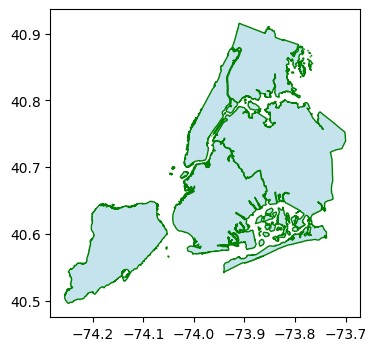

In [10]:

import requests

# Download the GeoJSON file and save it locally
url = 'https://github.com/codeforgermany/click_that_hood/raw/main/public/data/new-york-city-boroughs.geojson'
response = requests.get(url)
with open('new-york-city-boroughs.geojson', 'wb') as file:
    file.write(response.content)

# Read the locally saved GeoJSON file
borough_map = gpd.read_file('new-york-city-boroughs.geojson')
fig, ax = plt.subplots(figsize = (4, 4))
borough_map['geometry'].boundary.plot(edgecolor='green', linewidth=1, ax=ax)
borough_map.plot(color='lightblue', alpha=0.7, ax=ax)

### What type of housing complaint should be prioritized first based on frequency, severity, and other factors in the 311 data?

In [11]:
data.complaint_type.nunique()

29

There are 29 different complaint types

In [12]:
data.complaint_type.value_counts()

complaint_type
HEAT/HOT WATER            1149978
HEATING                    887869
PLUMBING                   702046
GENERAL CONSTRUCTION       500863
UNSANITARY CONDITION       434830
PAINT - PLASTER            361258
PAINT/PLASTER              340753
ELECTRIC                   303115
NONCONST                   260890
DOOR/WINDOW                199443
WATER LEAK                 186913
GENERAL                    145825
FLOORING/STAIRS            135159
APPLIANCE                  109480
HPD Literature Request      52830
SAFETY                      49904
OUTSIDE BUILDING             7015
ELEVATOR                     6397
Unsanitary Condition         5499
CONSTRUCTION                 5078
General                      1163
Safety                        424
STRUCTURAL                     16
Plumbing                       11
AGENCY                          9
VACANT APARTMENT                8
Outside Building                6
Appliance                       4
Mold                            1

In [13]:
data.groupby(['Year'])['complaint_type'].agg(pd.Series.mode)

Year
2010           HEATING
2011           HEATING
2012           HEATING
2013           HEATING
2014    HEAT/HOT WATER
2015    HEAT/HOT WATER
2016    HEAT/HOT WATER
2017    HEAT/HOT WATER
2018    HEAT/HOT WATER
2019    HEAT/HOT WATER
Name: complaint_type, dtype: object



- Heat/Hot Water and Heating complaints could be combined into a general "Heat Issue" category. Since they are the top two most frequent complaint types, merging them would consolidate the most common issues.

- Plumbing, Water Leak, and Mold complaints could be merged into a "Plumbing Issue" or "Water Issue" category. These issues seem related to general plumbing systems. 

- General Construction and NonConst complaints could be combined into a broader "Construction Issue" category to cover all construction-related concerns.

- Paint/Plaster and Paint-Plaster complaints seem duplicative and could be merged into a "Paint Issue" category.

- Door/Window, Flooring/Stairs complaints could potentially be grouped into a "Features/Fixtures Issue" category covering issues with appliances, doors, floors etc.

- Safety and Outside Building complaints could be merged into a "Building Exterior Issue" category encompassing external building/safety issues.

- Electrical, Elevator, and Appliance complaints may fit into an "Electrical/Mechanical Issue" category covering power, mechanical and electrical system issues.


In [14]:


# Merge Heat/Hot Water and Heating
data.loc[data['complaint_type'] == 'HEATING', 'complaint_type'] = 'HEAT/HOT WATER'

# Merge Paint/Plaster and Paint - Plaster
data.loc[data['complaint_type'] == 'PAINT - PLASTER', 'complaint_type'] = 'PAINT/PLASTER'

# Merge Plumbing, Water Leak, and Mold  
data.loc[data['complaint_type'].isin(['WATER LEAK', 'MOLD']), 'complaint_type'] = 'PLUMBING'

# Merge General Construction and NonConst
data.loc[data['complaint_type'] == 'NONCONST', 'complaint_type'] = 'GENERAL CONSTRUCTION'

# Merge Door/Window, Flooring/Stairs, and Appliance
data.loc[data['complaint_type'].isin(['DOOR/WINDOW', 'FLOORING/STAIRS']), 'complaint_type'] = 'APPLIANCE'

# Merge Safety and Outside Building 
data.loc[data['complaint_type'] == 'OUTSIDE BUILDING', 'complaint_type'] = 'SAFETY'

# Merge Electrical, Elevator, and Appliance
data.loc[data['complaint_type'].isin(['ELEVATOR', 'APPLIANCE']), 'complaint_type'] = 'ELECTRIC'

data.loc[data['complaint_type'].isin(['General']), 'complaint_type'] = 'GENERAL'

In [15]:
data.groupby(['Year'])['complaint_type'].agg(pd.Series.mode)

Year
2010          HEAT/HOT WATER
2011    GENERAL CONSTRUCTION
2012          HEAT/HOT WATER
2013          HEAT/HOT WATER
2014          HEAT/HOT WATER
2015          HEAT/HOT WATER
2016          HEAT/HOT WATER
2017          HEAT/HOT WATER
2018          HEAT/HOT WATER
2019          HEAT/HOT WATER
Name: complaint_type, dtype: object

In [16]:
print("Top 5 complaints")
data.complaint_type.value_counts().head()


Top 5 complaints


complaint_type
HEAT/HOT WATER          2037847
PLUMBING                 888959
GENERAL CONSTRUCTION     761753
ELECTRIC                 753594
PAINT/PLASTER            702011
Name: count, dtype: int64

To better visualize the distribution of complaint types, the less frequent categories were consolidated into a new combined "Rest" complaint type. This merging of long-tail complaint types simplifies the analysis by reducing the number of categories to focus on the most common issues.

In [17]:
data.complaint_type.value_counts()

complaint_type
HEAT/HOT WATER            2037847
PLUMBING                   888959
GENERAL CONSTRUCTION       761753
ELECTRIC                   753594
PAINT/PLASTER              702011
UNSANITARY CONDITION       434830
GENERAL                    146988
SAFETY                      56919
HPD Literature Request      52830
Unsanitary Condition         5499
CONSTRUCTION                 5078
Safety                        424
STRUCTURAL                     16
Plumbing                       11
AGENCY                          9
VACANT APARTMENT                8
Outside Building                6
Appliance                       4
Mold                            1
Name: count, dtype: int64

In [18]:
data_copy = data.copy()

category = data['complaint_type'].value_counts().sort_values().head(11).index
category

Index(['Mold', 'Appliance', 'Outside Building', 'VACANT APARTMENT', 'AGENCY',
       'Plumbing', 'STRUCTURAL', 'Safety', 'CONSTRUCTION',
       'Unsanitary Condition', 'HPD Literature Request'],
      dtype='object', name='complaint_type')

In [19]:
data_copy.loc[data_copy['complaint_type'].isin(category), 'complaint_type'] = 'Rest'

In [20]:
complaints = data_copy['complaint_type'].value_counts().sort_values()

In [21]:
complaints

complaint_type
SAFETY                    56919
Rest                      63886
GENERAL                  146988
UNSANITARY CONDITION     434830
PAINT/PLASTER            702011
ELECTRIC                 753594
GENERAL CONSTRUCTION     761753
PLUMBING                 888959
HEAT/HOT WATER          2037847
Name: count, dtype: int64

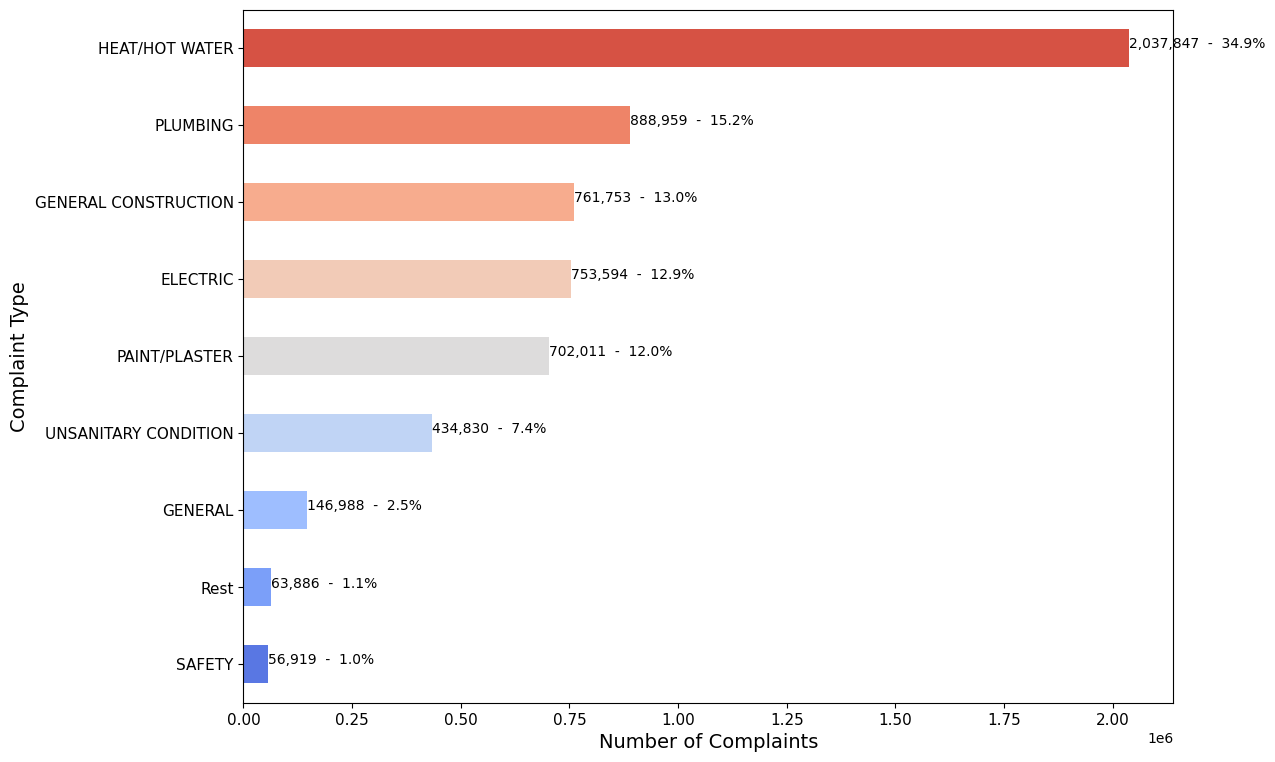

In [22]:
complaints.plot(kind='barh', figsize=(12, 9), fontsize=11, color=sns.color_palette('coolwarm', len(complaints)))
plt.ylabel('Complaint Type', fontsize=14)
plt.xlabel('Number of Complaints', fontsize=14)

for index, value in enumerate(complaints):
    label = str(format(int(value), ',')) + '  -  {}%'.format(round( (value/complaints.sum())*100, 1)) 
    plt.annotate(label, xy = (value , index ), color = 'black')

Heating water is the most complained type in the industry, with 34.9% of all complaints. This is followed by plumbing (15.2%), general construction (13.0%), paint/plaster (12.0%), and unsanitary condition (7.4%).

In [23]:
data.groupby(['Year'])['complaint_type'].agg(pd.Series.mode)

Year
2010          HEAT/HOT WATER
2011    GENERAL CONSTRUCTION
2012          HEAT/HOT WATER
2013          HEAT/HOT WATER
2014          HEAT/HOT WATER
2015          HEAT/HOT WATER
2016          HEAT/HOT WATER
2017          HEAT/HOT WATER
2018          HEAT/HOT WATER
2019          HEAT/HOT WATER
Name: complaint_type, dtype: object

it looks like "HEAT/HOT WATER" is the most common complaint type for all years from 2010 to 2019.

Are certain boroughs, ZIP codes, or streets experiencing more severe complaints of this top priority type?



In [24]:
area_data = data[['borough', 'incident_zip', 'street_name', 'latitude', 'longitude', 'complaint_type']]
area_data = area_data[area_data['complaint_type'] == 'HEAT/HOT WATER']
area_data.head()

,borough,incident_zip,street_name,latitude,longitude,complaint_type
0,MANHATTAN,10032.0,WEST 160 STREET,40.835396,-73.942262,HEAT/HOT WATER
19,MANHATTAN,10026.0,WEST 113 STREET,40.801529,-73.954533,HEAT/HOT WATER
20,QUEENS,11691.0,DIX AVENUE,40.606587,-73.755868,HEAT/HOT WATER
38,MANHATTAN,10031.0,WEST 134 STREET,40.818604,-73.953625,HEAT/HOT WATER
43,BROOKLYN,11226.0,CROOKE AVENUE,40.651999,-73.964560,HEAT/HOT WATER


In [25]:
area_data.shape

(2037847, 6)

In [26]:
area_data.isnull().sum().sort_values()

borough               0
complaint_type        0
street_name           1
latitude          18965
longitude         18965
incident_zip      18969
dtype: int64

In [27]:
percentages = (area_data.isnull().sum()*100/area_data.shape[0]).sort_values()

nan_data = pd.concat([area_data.isnull().sum().sort_values(), percentages], axis=1, keys=['Counts','%'])
nan_data

,Counts,%
borough,0,0.000000
complaint_type,0,0.000000
street_name,1,0.000049
latitude,18965,0.930639
longitude,18965,0.930639
incident_zip,18969,0.930835


<Axes: >

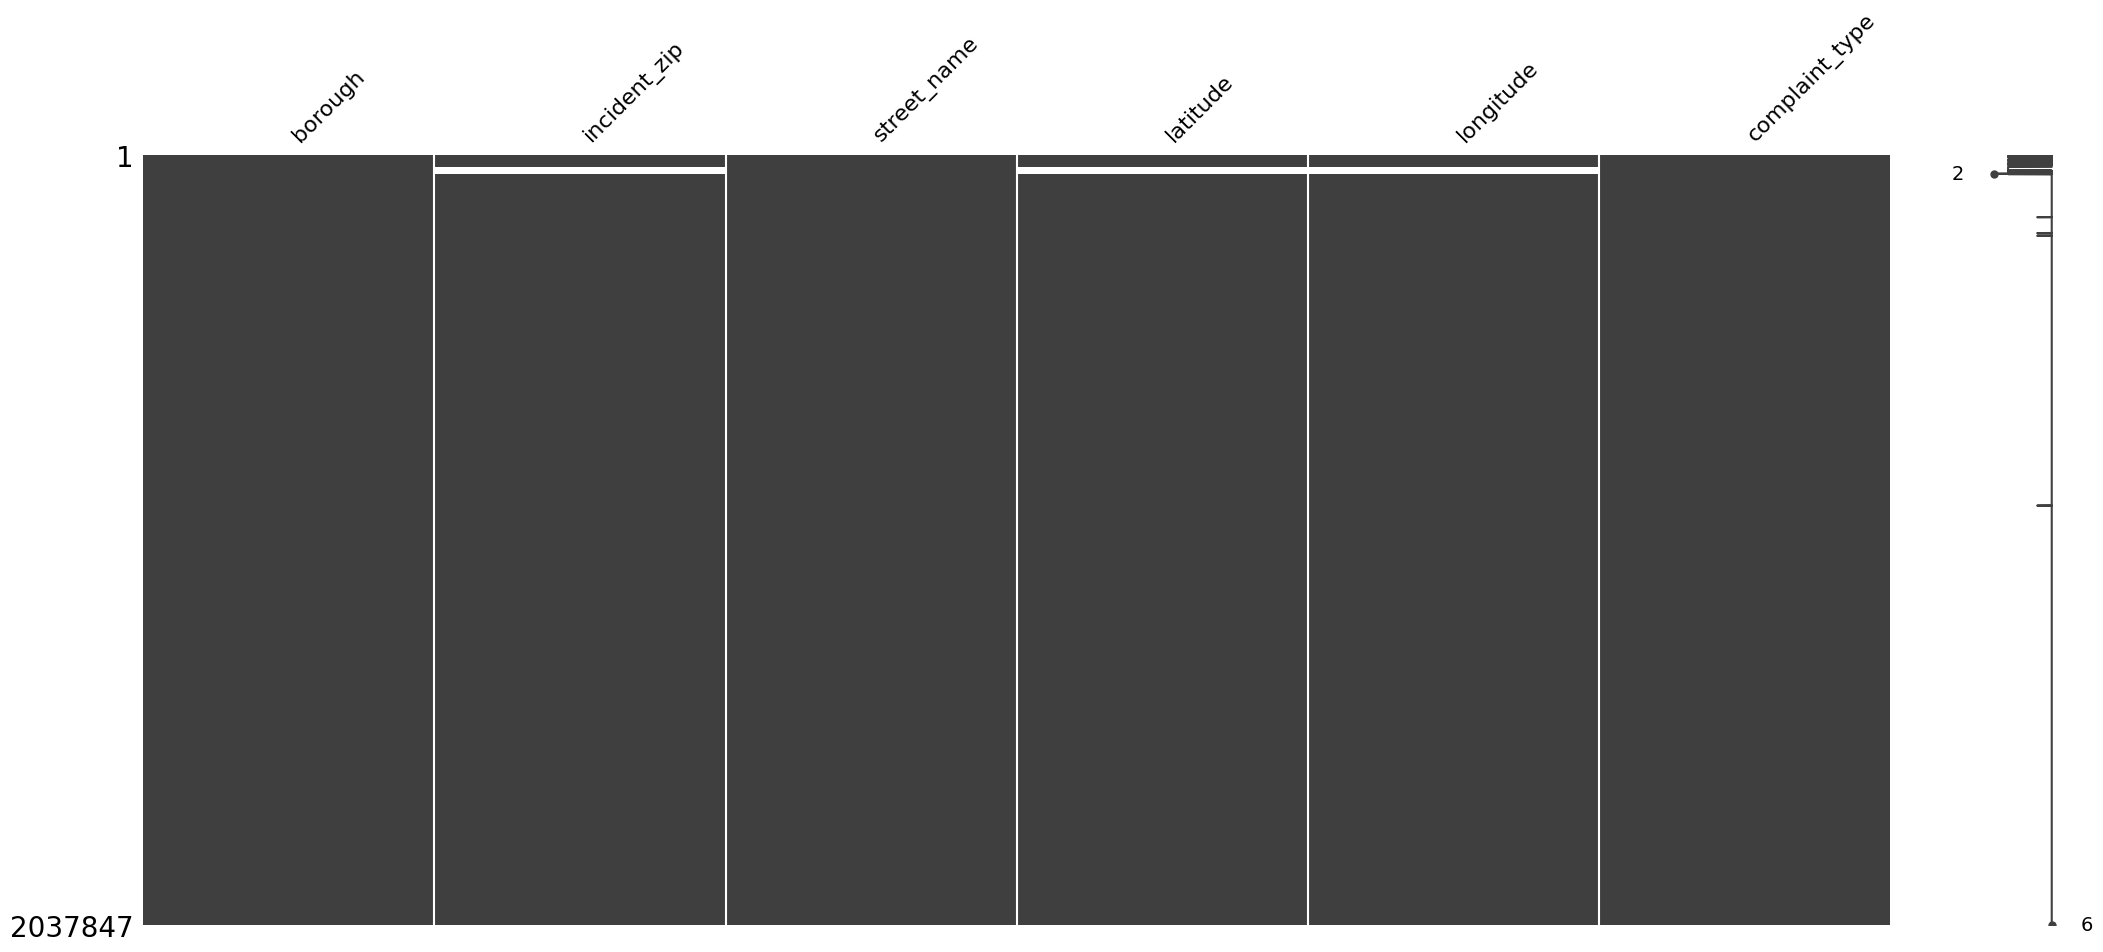

In [28]:
msno.matrix(area_data)

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from scipy import stats

In [30]:
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

In [31]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score, cross_val_predict,GridSearchCV, StratifiedKFold,learning_curve
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


In [32]:
label_size = 17
plt.rcParams['axes.labelsize'] = label_size
plt.rcParams['axes.titlesize'] = label_size
plt.rcParams['xtick.labelsize'] = label_size-3
plt.rcParams['ytick.labelsize'] = label_size-3

In [33]:
random_state = 42
scoring_metric = 'accuracy'